In [1]:
import Preprocessing as pp
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
temp_data_folder = "../Data/Temp_Data/"
image_path = "../Images/"
image_subfolder = "Proposal/"
image_folder = image_path + image_subfolder

pp.checkFolder(temp_data_folder)
pp.checkFolder(image_path)
pp.checkFolder(image_folder)

Folder already exists.
Folder already exists.
Folder already exists.


In [3]:
#colors
kit_green = '#009682'
kit_blue = '#4664AA'
kit_orange = '#DF9B1B'

In [4]:
df_1 = pp.openCSVFile('experiment_1_short.csv', temp_data_folder)
df_4b = pp.openCSVFile('experiment_4b_short.csv', temp_data_folder)
df_9 = pp.openCSVFile('experiment_9_short.csv', temp_data_folder)

In [5]:
data = df_4b.set_index('time').diff(10)

In [6]:
diff_1 = df_1.set_index('time').diff(10)

In [7]:
el_maxi = df_4b.loc[df_4b.idxmax()['el_power']]['el_power']
el_mini = df_4b.loc[df_4b.idxmin()['el_power']]['el_power']

## Dynamic Shift and supervised learning 

In [8]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [9]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [10]:
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [11]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler = scaler.fit(train)
    
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [12]:
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

## Enough of the chit chat 

In [13]:
y_train = df_4b['el_power']
y_train_dif = data['el_power']
X_train = df_4b['input_voltage']
train = [X_train, y_train]

y_test = df_1['el_power']
y_test_dif = diff_1['el_power']
X_test = df_1['input_voltage']
test = [X_test, y_test]

In [14]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=10)

In [15]:
def fit_lstm(X_train, y_train, X_test, y_test, batch_size, nb_epoch, neurons):
    X, y = X_train, y_train
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=500, batch_size=batch_size, verbose=2, shuffle=False, validation_data=(X_t, y_test), callbacks = [es])
        model.reset_states()
    return model

In [16]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [17]:
X_train = np.array(X_train[:,])
X_test = np.array(X_test[:,])
y_train = np.array(y_train[:,])
y_test = np.array(y_test[:,])

In [18]:
scaler, X_train, X_test = scale(X_train.reshape(-1,1), X_test.reshape(-1,1))
scaler_y, y_train, y_test = scale(y_train.reshape(-1,1), y_test.reshape(-1,1))

In [19]:
lstm_model = fit_lstm(X_train, y_train, X_test, y_test, 1, 50, 7)

Epoch 1/500
10540/10540 - 12s - loss: 0.0011 - val_loss: 0.0366
Epoch 2/500
10540/10540 - 12s - loss: 0.0014 - val_loss: 0.0675
Epoch 3/500
10540/10540 - 11s - loss: 0.0020 - val_loss: 0.0371
Epoch 4/500
10540/10540 - 11s - loss: 0.0025 - val_loss: 0.0438
Epoch 5/500
10540/10540 - 11s - loss: 0.0030 - val_loss: 0.0390
Epoch 6/500
10540/10540 - 11s - loss: 0.0038 - val_loss: 0.0389
Epoch 7/500
10540/10540 - 11s - loss: 0.0045 - val_loss: 0.0360
Epoch 8/500
10540/10540 - 11s - loss: 0.0052 - val_loss: 0.0343
Epoch 9/500
10540/10540 - 11s - loss: 0.0057 - val_loss: 0.0369
Epoch 10/500
10540/10540 - 11s - loss: 0.0050 - val_loss: 0.0468
Epoch 11/500
10540/10540 - 11s - loss: 0.0038 - val_loss: 0.0469
Epoch 12/500
10540/10540 - 11s - loss: 0.0019 - val_loss: 0.1439
Epoch 13/500
10540/10540 - 11s - loss: 2.9726e-04 - val_loss: 0.2801
Epoch 14/500
10540/10540 - 11s - loss: 1.3719e-04 - val_loss: 0.0685
Epoch 15/500
10540/10540 - 11s - loss: 1.2828e-04 - val_loss: 0.0294
Epoch 16/500
10540/105

Epoch 36/500
10540/10540 - 11s - loss: 0.0070 - val_loss: 0.0666
Epoch 37/500
10540/10540 - 11s - loss: 0.0059 - val_loss: 0.5205
Epoch 38/500
10540/10540 - 11s - loss: 0.0031 - val_loss: 0.1172
Epoch 39/500
10540/10540 - 11s - loss: 0.0017 - val_loss: 0.2720
Epoch 40/500
10540/10540 - 11s - loss: 0.0019 - val_loss: 0.3853
Epoch 41/500
10540/10540 - 11s - loss: 0.0027 - val_loss: 0.6746
Epoch 42/500
10540/10540 - 11s - loss: 0.0051 - val_loss: 0.7145
Epoch 43/500
10540/10540 - 11s - loss: 0.0063 - val_loss: 0.5665
Epoch 44/500
10540/10540 - 11s - loss: 0.0052 - val_loss: 0.5675
Epoch 00044: early stopping
Epoch 1/500
10540/10540 - 11s - loss: 0.0027 - val_loss: 0.6493
Epoch 2/500
10540/10540 - 11s - loss: 0.0059 - val_loss: 0.3519
Epoch 3/500
10540/10540 - 11s - loss: 0.0023 - val_loss: 0.0176
Epoch 4/500
10540/10540 - 11s - loss: 3.2424e-04 - val_loss: 0.3782
Epoch 5/500
10540/10540 - 11s - loss: 0.0020 - val_loss: 0.0766
Epoch 6/500
10540/10540 - 11s - loss: 2.4694e-04 - val_loss: 0.

Epoch 15/500
10540/10540 - 11s - loss: 1.3340e-04 - val_loss: 0.0104
Epoch 16/500
10540/10540 - 11s - loss: 1.3323e-04 - val_loss: 0.0102
Epoch 17/500
10540/10540 - 11s - loss: 1.3310e-04 - val_loss: 0.0100
Epoch 18/500
10540/10540 - 11s - loss: 1.3301e-04 - val_loss: 0.0098
Epoch 19/500
10540/10540 - 11s - loss: 1.3296e-04 - val_loss: 0.0096
Epoch 20/500
10540/10540 - 11s - loss: 1.3297e-04 - val_loss: 0.0094
Epoch 21/500
10540/10540 - 11s - loss: 1.3304e-04 - val_loss: 0.0091
Epoch 22/500
10540/10540 - 11s - loss: 1.3318e-04 - val_loss: 0.0089
Epoch 23/500
10540/10540 - 11s - loss: 1.3340e-04 - val_loss: 0.0087
Epoch 24/500
10540/10540 - 11s - loss: 1.3372e-04 - val_loss: 0.0084
Epoch 25/500
10540/10540 - 11s - loss: 1.3413e-04 - val_loss: 0.0082
Epoch 26/500
10540/10540 - 11s - loss: 1.3465e-04 - val_loss: 0.0079
Epoch 27/500
10540/10540 - 11s - loss: 1.3531e-04 - val_loss: 0.0078
Epoch 28/500
10540/10540 - 11s - loss: 1.3625e-04 - val_loss: 0.0076
Epoch 29/500
10540/10540 - 11s - l

Epoch 19/500
10540/10540 - 11s - loss: 1.5228e-04 - val_loss: 0.0132
Epoch 20/500
10540/10540 - 11s - loss: 1.6250e-04 - val_loss: 0.0151
Epoch 00020: early stopping
Epoch 1/500
10540/10540 - 11s - loss: 2.1709e-04 - val_loss: 0.0148
Epoch 2/500
10540/10540 - 11s - loss: 4.1847e-04 - val_loss: 0.0094
Epoch 3/500
10540/10540 - 11s - loss: 0.0020 - val_loss: 0.0452
Epoch 4/500
10540/10540 - 11s - loss: 4.4273e-04 - val_loss: 0.0388
Epoch 5/500
10540/10540 - 11s - loss: 1.9988e-04 - val_loss: 0.0262
Epoch 6/500
10540/10540 - 11s - loss: 2.0566e-04 - val_loss: 0.0186
Epoch 7/500
10540/10540 - 11s - loss: 2.0977e-04 - val_loss: 0.0137
Epoch 8/500
10540/10540 - 11s - loss: 2.1041e-04 - val_loss: 0.0100
Epoch 9/500
10540/10540 - 11s - loss: 0.0011 - val_loss: 0.0305
Epoch 10/500
10540/10540 - 11s - loss: 2.1597e-04 - val_loss: 0.0124
Epoch 11/500
10540/10540 - 11s - loss: 2.0906e-04 - val_loss: 0.0101
Epoch 12/500
10540/10540 - 11s - loss: 2.3841e-04 - val_loss: 0.0340
Epoch 00012: early stop

10540/10540 - 11s - loss: 5.7462e-04 - val_loss: 0.0197
Epoch 4/500
10540/10540 - 11s - loss: 3.0455e-04 - val_loss: 0.0140
Epoch 5/500
10540/10540 - 11s - loss: 2.2163e-04 - val_loss: 0.0122
Epoch 6/500
10540/10540 - 11s - loss: 2.2001e-04 - val_loss: 0.0118
Epoch 7/500
10540/10540 - 11s - loss: 2.6167e-04 - val_loss: 0.0116
Epoch 8/500
10540/10540 - 11s - loss: 2.9502e-04 - val_loss: 0.0119
Epoch 9/500
10540/10540 - 11s - loss: 3.1570e-04 - val_loss: 0.0124
Epoch 10/500
10540/10540 - 11s - loss: 3.3177e-04 - val_loss: 0.0128
Epoch 11/500
10540/10540 - 11s - loss: 3.4997e-04 - val_loss: 0.0130
Epoch 12/500
10540/10540 - 11s - loss: 3.7235e-04 - val_loss: 0.0131
Epoch 13/500
10540/10540 - 11s - loss: 3.9539e-04 - val_loss: 0.0129
Epoch 14/500
10540/10540 - 11s - loss: 4.1567e-04 - val_loss: 0.0118
Epoch 15/500
10540/10540 - 11s - loss: 4.3820e-04 - val_loss: 0.0091
Epoch 16/500
10540/10540 - 11s - loss: 4.7396e-04 - val_loss: 0.0076
Epoch 17/500
10540/10540 - 11s - loss: 5.2649e-04 - v

Epoch 6/500
10540/10540 - 11s - loss: 0.0069 - val_loss: 0.0328
Epoch 7/500
10540/10540 - 11s - loss: 0.0067 - val_loss: 0.0375
Epoch 8/500
10540/10540 - 11s - loss: 0.0066 - val_loss: 0.0432
Epoch 9/500
10540/10540 - 11s - loss: 0.0084 - val_loss: 0.0437
Epoch 10/500
10540/10540 - 11s - loss: 0.0109 - val_loss: 0.0427
Epoch 11/500
10540/10540 - 11s - loss: 0.0105 - val_loss: 0.0415
Epoch 12/500
10540/10540 - 11s - loss: 0.0100 - val_loss: 0.0388
Epoch 13/500
10540/10540 - 11s - loss: 0.0100 - val_loss: 0.0356
Epoch 14/500
10540/10540 - 11s - loss: 0.0098 - val_loss: 0.0308
Epoch 00014: early stopping
Epoch 1/500
10540/10540 - 11s - loss: 0.0097 - val_loss: 0.0245
Epoch 2/500
10540/10540 - 11s - loss: 0.0076 - val_loss: 0.0315
Epoch 3/500
10540/10540 - 11s - loss: 0.0150 - val_loss: 0.0297
Epoch 4/500
10540/10540 - 11s - loss: 0.0095 - val_loss: 0.0339
Epoch 5/500
10540/10540 - 11s - loss: 0.0082 - val_loss: 0.0330
Epoch 6/500
10540/10540 - 11s - loss: 0.0135 - val_loss: 0.0314
Epoch 7

Epoch 7/500
10540/10540 - 11s - loss: 0.0073 - val_loss: 0.0452
Epoch 8/500
10540/10540 - 11s - loss: 0.0072 - val_loss: 0.0444
Epoch 9/500
10540/10540 - 11s - loss: 0.0071 - val_loss: 0.0438
Epoch 10/500
10540/10540 - 11s - loss: 0.0070 - val_loss: 0.0433
Epoch 11/500
10540/10540 - 11s - loss: 0.0067 - val_loss: 0.0421
Epoch 12/500
10540/10540 - 11s - loss: 0.0063 - val_loss: 0.0412
Epoch 13/500
10540/10540 - 11s - loss: 0.0053 - val_loss: 0.0409
Epoch 14/500
10540/10540 - 11s - loss: 0.0042 - val_loss: 0.0441
Epoch 15/500
10540/10540 - 11s - loss: 0.0072 - val_loss: 2.4394
Epoch 16/500
10540/10540 - 11s - loss: 0.1385 - val_loss: 0.3663
Epoch 17/500
10540/10540 - 11s - loss: 0.0222 - val_loss: 0.0735
Epoch 18/500
10540/10540 - 11s - loss: 7.7996e-04 - val_loss: 0.0459
Epoch 19/500
10540/10540 - 11s - loss: 0.0013 - val_loss: 0.0414
Epoch 20/500
10540/10540 - 11s - loss: 0.0024 - val_loss: 0.0519
Epoch 21/500
10540/10540 - 11s - loss: 0.0038 - val_loss: 0.1056
Epoch 22/500
10540/10540

Epoch 4/500
10540/10540 - 11s - loss: 0.0050 - val_loss: 0.0400
Epoch 5/500
10540/10540 - 11s - loss: 0.0053 - val_loss: 0.0401
Epoch 6/500
10540/10540 - 11s - loss: 0.0053 - val_loss: 0.0399
Epoch 7/500
10540/10540 - 11s - loss: 0.0052 - val_loss: 0.0398
Epoch 8/500
10540/10540 - 11s - loss: 0.0057 - val_loss: 0.0459
Epoch 9/500
10540/10540 - 11s - loss: 0.0065 - val_loss: 0.0473
Epoch 10/500
10540/10540 - 11s - loss: 0.0053 - val_loss: 0.0399
Epoch 11/500
10540/10540 - 11s - loss: 0.0041 - val_loss: 0.0386
Epoch 12/500
10540/10540 - 11s - loss: 0.0037 - val_loss: 0.0400
Epoch 00012: early stopping
Epoch 1/500
10540/10540 - 11s - loss: 0.0121 - val_loss: 0.0377
Epoch 2/500
10540/10540 - 11s - loss: 0.0048 - val_loss: 0.0385
Epoch 3/500
10540/10540 - 11s - loss: 0.0051 - val_loss: 0.0390
Epoch 4/500
10540/10540 - 11s - loss: 0.0052 - val_loss: 0.0393
Epoch 5/500
10540/10540 - 11s - loss: 0.0053 - val_loss: 0.0397
Epoch 6/500
10540/10540 - 11s - loss: 0.0053 - val_loss: 0.0400
Epoch 7/5

Epoch 00011: early stopping
Epoch 1/500
10540/10540 - 11s - loss: 0.0041 - val_loss: 0.0374
Epoch 2/500
10540/10540 - 11s - loss: 0.0056 - val_loss: 0.0384
Epoch 3/500
10540/10540 - 11s - loss: 0.0064 - val_loss: 0.0392
Epoch 4/500
10540/10540 - 11s - loss: 0.0067 - val_loss: 0.0395
Epoch 5/500
10540/10540 - 11s - loss: 0.0068 - val_loss: 0.0396
Epoch 6/500
10540/10540 - 11s - loss: 0.0069 - val_loss: 0.0396
Epoch 7/500
10540/10540 - 11s - loss: 0.0069 - val_loss: 0.0395
Epoch 8/500
10540/10540 - 11s - loss: 0.0069 - val_loss: 0.0395
Epoch 9/500
10540/10540 - 11s - loss: 0.0069 - val_loss: 0.0394
Epoch 10/500
10540/10540 - 11s - loss: 0.0069 - val_loss: 0.0393
Epoch 11/500
10540/10540 - 11s - loss: 0.0069 - val_loss: 0.0393
Epoch 00011: early stopping
Epoch 1/500
10540/10540 - 11s - loss: 0.0111 - val_loss: 0.0402
Epoch 2/500
10540/10540 - 11s - loss: 0.0072 - val_loss: 0.0397
Epoch 3/500
10540/10540 - 11s - loss: 0.0071 - val_loss: 0.0394
Epoch 4/500
10540/10540 - 11s - loss: 0.0071 -

In [20]:
y_train_reshaped = y_train[:, 0].reshape(len(y_train), 1, 1)
lstm_model.predict(y_train_reshaped, batch_size=1)

array([[0.75147295],
       [0.5896614 ],
       [0.4527883 ],
       ...,
       [0.02850652],
       [0.02900475],
       [0.02912229]], dtype=float32)

In [21]:
X_test_reshaped = X_test[:, 0].reshape(len(X_test), 1, 1)
pred = lstm_model.predict(X_test_reshaped, batch_size=1)

In [22]:
sc = MinMaxScaler(feature_range= (el_mini, el_maxi))
sc.fit(y_test)

MinMaxScaler(feature_range=(1132.0, 3386.0))

In [23]:
predictions = sc.transform(pred)
y_test_true = sc.transform(y_test)

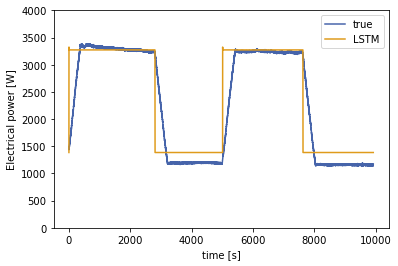

In [24]:
import time
timestr = time.strftime("%Y-%m-%d_%H-%M")

pyplot.plot(y_test_true, label = 'true', color = kit_blue)
pyplot.plot(predictions, label = 'LSTM', color = kit_orange)

pyplot.legend()
pyplot.ylabel('Electrical power [W]')
pyplot.ylim([0, 4000])
pyplot.xlabel('time [s]')

pyplot.savefig(image_folder + timestr + '_ex1_LSTM_electric.svg')
pyplot.savefig(image_folder + timestr + '_ex1_LSTM_electric.png')
pyplot.show()

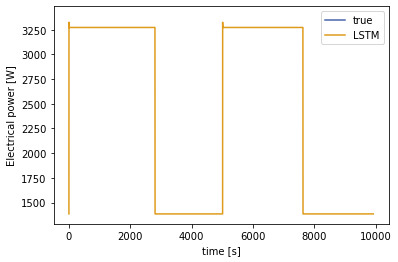

In [25]:
pyplot.plot(invert_scale(scaler_y, y_test, 1), label = 'true', color = kit_blue)
pyplot.plot(predictions, label = 'LSTM', color = kit_orange)

pyplot.legend()
pyplot.ylabel('Electrical power [W]')
#pyplot.ylim([0, 4000])
pyplot.xlabel('time [s]')

# pyplot.savefig(image_folder + 'ex1_LSTM_electric.svg')
# pyplot.savefig(image_folder + 'ex1_LSTM_electric.png')
pyplot.show()